<a href="https://colab.research.google.com/github/ArjunNarayan2066/CS484_project/blob/main/cs484_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Self-Supervised Monocular Depth Estimation

by Oswaldo Ferro (oferro) and Arjun Narayan (amnaraya)

# Abstract and Motivation

Self-supervised depth estimation consists on training a neural network to provide dense pixel-wise depth predictions given a single image. "Self-supervision"  in the training process implies not relying on ground truth depth maps, which can be hard and expensive to acquire. The motivation behind this project is to reduce the costs associated with requiring high-fidelity ground truth data for training monocular depth estimation networks, given that high quality data in large quantities can be hard and expensive to generate. The applications of a monocular depth estimation neural network are clear in fields such as Augmented Reality, where a mesh of the world must be generated for the virtual content to make sense in the real scene; given that some phones only have a single camera, applying stereo reconstruction algorithms for 3D scene reconstruction is impossible. Another option is Structure from Motion, but SfM techniques tend to provide only spars point clouds, which might not be dense enough to provide a good enough understanding of the environment, and require processing many consecutive frames in near real-time. Having a way to estimate dense depth maps from a single camera would be directly applicable for mapping applications. Other applications include robotics, in which hardware cost is significant, and as such, minimizing the number of cameras/LiDARS/Sonars on board would reduce the overall development costs.

The network developed in this project is inspired by "Digging Into Self-Supervised Monocular Depth Estimation" by Godard et. al [1]. Modifications are applied to the loss function, aiming to improve the accuracy of the depth prediction around depth discontinuities at object edges. These modifications will be discussed in detail later in the project.

The network attempts to generate a synthetic view of the same scene from a different point of view. This implicitly generated a disparity map, if per-pixel correspondences are known. The relative pose of the virtual viewpoint with respect to the actual viewpoint (i.e. real camera) is represented as $T_{t' \rightarrow t}$, and the synthetic image is denoted $I_{t'}$, given an original image $I_t$.

The loss functions employed in the training are as follows. 
$$L_p = \Sigma_{t'} pe( I_{t}, I_{t'\rightarrow t})$$

where $pe$ is defined as:

$$pe(I, I_s) = \frac{\alpha}{2}(1-SSIM(I, I_s)) + (1-\alpha) ||I - I_s||_1$$

where $I_s$ is the synthetic image prediction. $\alpha$ is set to 0.85, as per empirical results from [1].

$SSIM$ represents structural similarity between images $I_a$ and $I_b$. That is, the sum of x and y distances for all matches:

$$SSIM(x, y) = \frac{(2\mu_x\mu_y+c_1)(2\sigma_{xy}+c_2)}{(\mu_x^2+\mu_y^2+c_1)(\sigma_x^2+\sigma_y^2+c_2)}$$

$I_{t'\rightarrow t}$ is defined as follows:

$$I_{t'\rightarrow t} = I_{t'}\langle proj(D_t, T_{t\rightarrow t'}, K)\rangle$$

for $D_t$ being projected depths, $\langle . \rangle$ being the sampling operator.

Note that the $pe$ function provides a weighted sum of visually perceptible differences between images (SSIM), and the L1 norm between said images, as described in [2]. Modifications were made to this loss function in order to improve model performance. These modifications will be discussed in detail further down.

The data used to train the network is a subset of the standard Eigen split of the KITTI Dataset [http://www.cvlibs.net/datasets/kitti/raw_data.php]



# Team Members and Contributions

Arjun Narayan (amnaraya, ID: 20660737):
- Training loop
- Initial Loss functions
- Overall training boilerplate code
- Training vs. validation comparisons

Oswaldo Ferro (oferro, ID: 20657873):
- Data pre-processing and clean-up
- Image batch gradient computation
- Modified Loss functions (weigh loss proportional to gradient)
- U-Net network (pretrained ResNet encoder, and custom decoder with randomly initialized layers)
- Overall architectural choices
- Explanations and conclusion

## Code Libraries

The libraries used in this project are:

- pytorch: Common machine learning library
- kornia: Common image processing library with GPU support (similar to skimage, and can operate on Torch Tensors)
- monodepth: Used mainly the built-in utilities for working with the KITTI dataset, and extracting the ground truth depth maps for reporting results. Note that much of the data pre-processing, the training loop, and the network were still build from scratch.
- PIL and opencv: Common image manipulation libraries


In [2]:
! nvcc --version

! pip install tensorboardX==1.4
! pip install opencv-python==3.3.1.11
! git clone https://github.com/ArjunNarayan2066/monodepth2.git
! pip install kornia

! sudo apt update
# For converting the KITTI raw .png files to .jpg
! sudo apt install imagemagick --fix-missing
! sudo apt install parallel

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
     |████████████████████████████████| 71kB 3.9MB/s 
     |████████████████████████████████| 24.7MB 1.9MB/s 
ERROR: dopamine-rl 1.0.5 has requirement opencv-python>=3.4.1.15, but you'll have opencv-python 3.3.1.11 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 225kB 6.4MB/s 


In [4]:
%matplotlib notebook

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
from PIL import Image
import kornia

import torch
from torchvision import transforms


# Data processing

Download a subset of the KITTI dataset. Generate a list of all the downloaded files, append $l$ or $r$ corresponding to which one of the cameras in the stereo pair it was taken on.


In [ ]:
! wget -i monodepth2/splits/kitti_archives_to_download.txt -P kitti_data/

! unzip -o "kitti_data/*.zip" -d "kitti_data/"

# Convert to jpg. Less memory consumption, increases training speed due to faster loading times
! sudo apt update
! sudo apt install imagemagick
! sudo apt install parallel
! find kitti_data/ -name '*.png' | parallel 'convert -quality 92 -sampling-factor 2x2,1x1,1x1 {.}.png {.}.jpg && rm {}'


In [ ]:
! find kitti_data/ -type f -name '*.jpg' >> all_files.txt

The eigen_all_files.txt has info. about each image, regarding whether it's a Left or a Right stereo image. It was generated from a subset of the standard Eigen split for KITTI.

In [ ]:
fp = open('./all_files.txt', 'r')
all_lines = fp.readlines()
all_lines = [x.strip() for x in all_lines]


##########################################################
fp2 = open('monodepth2/splits/eigen_all_files.txt', 'r')
eigen_lines = fp2.readlines()
eigen_lines = [x.strip() for x in eigen_lines]

output_file = open("output_files_train.txt", "w")


eigen_dict = {}

for line in eigen_lines:
    filepath, number, RL = line.split(' ')
    number = str(int(number))

    key = ' '.join([filepath, number])

    eigen_dict[key] = RL

for i, _ in enumerate(all_lines):
    first_part = '/'.join( all_lines[i].split('/')[2:-3] )
    second_part = str(int(all_lines[i].split('/')[-1].split('.')[0])) #remove trailing zeros

    joined = ' '.join([first_part, second_part])
    
    if joined in eigen_dict:
        output_file.write(' '.join([joined, eigen_dict[joined]]))
        output_file.write('\n')

output_file.close()


In [ ]:
import torch
! uname -a
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

In [40]:

import numpy as np
import torch
import torch.nn as nn

from collections import OrderedDict
import monodepth2.layers

class DepthDecoder(nn.Module):
    def __init__(self, num_ch_enc, num_channels_out=1):
        super(DepthDecoder, self).__init__()

        self.num_channels_out = num_channels_out
        self.scales = [0,1,2,3]

        self.num_ch_enc = num_ch_enc
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])

        # decoder   
        self.convs = OrderedDict()

        ### 4 ###
        # upconv_0
        num_ch_in = self.num_ch_enc[-1]
        num_ch_out = self.num_ch_dec[4]
        self.convs[("upconv", 4, 0)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        # upconv_1
        num_ch_in = self.num_ch_dec[4]
        #skip connection
        num_ch_in += self.num_ch_enc[3]
        num_ch_out = self.num_ch_dec[4]
        self.convs[("upconv", 4, 1)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        ### 3 ###
        # upconv_0
        num_ch_in = self.num_ch_dec[4]
        num_ch_out = self.num_ch_dec[3]
        self.convs[("upconv", 3, 0)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        # upconv_1
        num_ch_in = self.num_ch_dec[3]
        #skip connection
        num_ch_in += self.num_ch_enc[2]
        num_ch_out = self.num_ch_dec[3]
        self.convs[("upconv", 3, 1)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        ### 2 ###
        # upconv_0
        num_ch_in = self.num_ch_dec[3]
        num_ch_out = self.num_ch_dec[2]
        self.convs[("upconv", 2, 0)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        # upconv_1
        num_ch_in = self.num_ch_dec[2]
        #skip connection
        num_ch_in += self.num_ch_enc[1]
        num_ch_out = self.num_ch_dec[2]
        self.convs[("upconv", 2, 1)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        ### 1 ###
        # upconv_0
        num_ch_in = self.num_ch_dec[2]
        num_ch_out = self.num_ch_dec[1]
        self.convs[("upconv", 1, 0)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        # upconv_1
        num_ch_in = self.num_ch_dec[1]
        #skip connection
        num_ch_in += self.num_ch_enc[0]
        num_ch_out = self.num_ch_dec[1]
        self.convs[("upconv", 1, 1)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        ### 0 ###
        # upconv_0
        num_ch_in = self.num_ch_dec[1]
        num_ch_out = self.num_ch_dec[0]
        self.convs[("upconv", 0, 0)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        # upconv_1
        num_ch_in = self.num_ch_dec[0]
        # No skip connection on the last layer
        num_ch_out = self.num_ch_dec[0]
        self.convs[("upconv", 0, 1)] = monodepth2.layers.ConvBlock(num_ch_in, num_ch_out)

        for s in self.scales:
            self.convs[("dispconv", s)] = monodepth2.layers.Conv3x3(self.num_ch_dec[s], self.num_channels_out)

        self.decoder = nn.ModuleList(list(self.convs.values()))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}

        x = input_features[-1]

        ### 4 ###
        x = self.convs[("upconv", 4, 0)](x)
        x = [upsample(x)]
        x += [input_features[3]]
        x = torch.cat(x, 1)
        x = self.convs[("upconv", 4, 1)](x)

        ### 3 ###
        x = self.convs[("upconv", 3, 0)](x)
        x = [upsample(x)]
        x += [input_features[2]]
        x = torch.cat(x, 1)
        x = self.convs[("upconv", 3, 1)](x)
        self.outputs[("disp", 3)] = self.sigmoid(self.convs[("dispconv", 3)](x))

        ### 2 ###
        x = self.convs[("upconv", 2, 0)](x)
        x = [upsample(x)]
        x += [input_features[1]]
        x = torch.cat(x, 1)
        x = self.convs[("upconv", 2, 1)](x)
        self.outputs[("disp", 2)] = self.sigmoid(self.convs[("dispconv", 2)](x))

        ### 1 ###
        x = self.convs[("upconv", 1, 0)](x)
        x = [upsample(x)]
        x += [input_features[0]]
        x = torch.cat(x, 1)
        x = self.convs[("upconv", 1, 1)](x)
        self.outputs[("disp", 1)] = self.sigmoid(self.convs[("dispconv", 1)](x))

        ### 0 ###
        x = self.convs[("upconv", 0, 0)](x)
        x = [upsample(x)]
        x = torch.cat(x, 1)
        x = self.convs[("upconv", 0, 1)](x)
        self.outputs[("disp", 0)] = self.sigmoid(self.convs[("dispconv", 0)](x))

        return self.outputs

## Loss function modifications

The modifications made to the loss function are as follows:


$$pe(I, I_s) = \frac{\alpha}{2}(1-SSIM(I, I_s)) + (1-\alpha) ||(I - I_s)\times\nabla I'||_1$$

where

$$\nabla I'= \sqrt{\Bigg(\frac{\partial I}{\partial x}\Bigg ) ^2+ \Bigg(\frac{\partial I}{\partial y}\Bigg) ^2}$$

That is, $\nabla I'$ is a scalar valued HxW image (where HxW are the original image dimensions), where each pixel represents the (Euclidean) magnitude of the image gradient at that point.

Note that $\nabla I$ is also normalized to the range $[1, 1+\beta]$, for $\beta<1$. Hence, scaling the difference between the original image $I$ and the synthetic image $I_s$ by the magnitude of the gradient will ensure the loss penalizes edge pixels more strongly, hence improving the depth map resolution around the edges of objects (depth discontinuities).

Note also that a gaussian blur with a 5x5 kernel with variance of 2 was applied to $\nabla I'$, which allows for smoother penalizations around the edges, and should make the loss be better behaved.


The get_gradient function below takes the magnitude of the total gradient at each pixel in the original image, and is used to weigh the loss term when computing the loss in gradient_weighted_reprojection further down.



In [41]:
def get_gradient(t, device, gauss_blur_sigma=None, kernel_size = 5):
  a = torch.Tensor([[1, 0, -1],
  [2, 0, -2],
  [1, 0, -1]]).to(device)

  a = a.view((1,1,3,3))
  G_x = F.conv2d(t, a, padding=1)

  b = torch.Tensor([[1, 2, 1],
  [0, 0, 0],
  [-1, -2, -1]]).to(device)

  b = b.view((1,1,3,3))
  G_y = F.conv2d(t, b, padding=1)

  G = torch.sqrt(torch.pow(G_x,2)+ torch.pow(G_y,2))


  if gauss_blur_sigma:
    G = kornia.gaussian_blur2d(G, (kernel_size, kernel_size), (gauss_blur_sigma, gauss_blur_sigma))

  G -= torch.min(G)
  G /= torch.max(G)


  return G

### Testing the gradient function:

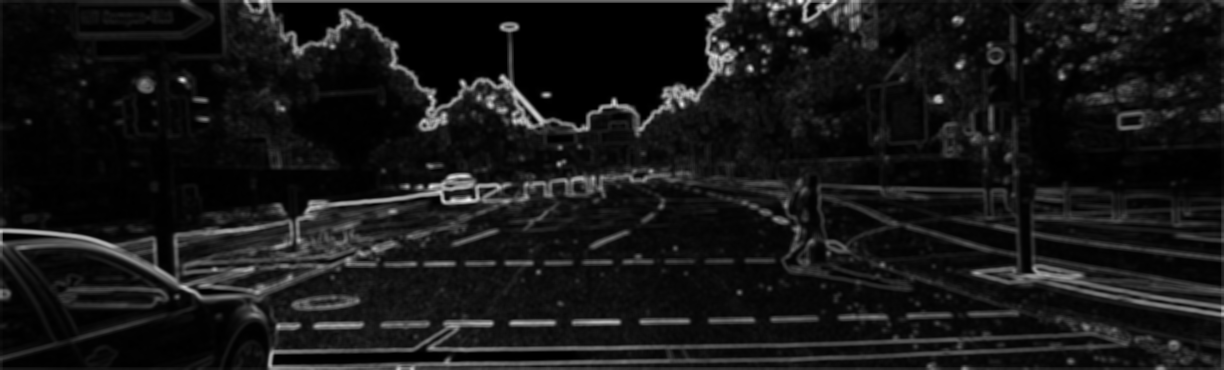

In [42]:

# Read in image
from PIL import Image
im = Image.open("./kitti_data/2011_09_28/2011_09_28_drive_0002_sync/image_00/data/0000000172.jpg")

# Convert to tensor and compute gradient
t = transforms.ToTensor()
t_im = t(im)[None]
t_im.shape
grad = get_gradient(t_im, torch.device("cpu"), gauss_blur_sigma=2)


t2 = transforms.ToPILImage()
g = t2(grad[0])

g


In [43]:
import os
import torchvision.models as models

def save_model(train):
    """Save model weights to disk
    """
    save_folder = os.path.join("/content/test_model/")
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    for model_name, model in train.models.items():
        save_path = os.path.join(save_folder, "{}.pth".format(model_name))
        to_save = model.state_dict()
        if 'encoder' in model_name:
            # save the sizes - these are needed at prediction time
            to_save['height'] = train.h
            to_save['width'] = train.w
            to_save['use_stereo'] = True
        torch.save(to_save, save_path)

    with open(os.path.join(save_folder, 'losses.txt'), 'w') as f:
        f.writelines("%s\n" % loss for loss in train.losses)

    save_path = os.path.join(save_folder, "{}.pth".format("adam"))
    torch.save(train.adam_optim.state_dict(), save_path)

In [51]:
###
###
### Training code is based on a very-stripped down version of https://arxiv.org/pdf/1806.01260.pdf
### Written only with stereo based training with reduced feature set
###
###


import monodepth2.layers, monodepth2.utils, monodepth2.trainer
import monodepth2.networks

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import timeit
import PIL.Image as pil


class MyTraining(object):
    def __init__(self, batch, epoch, weight_by_gradient=True):
        self.batch = batch
        self.epoch_max = epoch
        self.h = 192
        self.w = 640
        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        # For listing which frames to check
        # For simple stereo is only current (0) and estimated pair (s)
        self.frames = [0, 's']

        # For multi-scale estimation
        self.loss_scales = [0, 1, 2, 3]

        # Weighting for loss function
        self.alpha = 0.85

        # Weighting for loss at high-contrast regions
        self.weight_by_gradient = weight_by_gradient
        self.beta = 0.1 

        # Define projections for pose estimation
        self.depth_projection = {}
        self.projection_3d = {}
        for loss_scale in self.loss_scales:
            h = int(self.h / (2 ** loss_scale))
            w = int(self.w / (2 ** loss_scale))

            self.depth_projection[loss_scale] = monodepth2.layers.BackprojectDepth(self.batch, h, w).to(self.device)
            self.projection_3d[loss_scale] = monodepth2.layers.Project3D(self.batch, h, w).to(self.device)
        
        ## Declare Depth Network
        self.depth_encoder_network = monodepth2.networks.ResnetEncoder(18, True).to(self.device)
        self.depth_decoder_network = DepthDecoder(self.depth_encoder_network.num_ch_enc).to(self.device) 
        # self.depth_decoder_network = monodepth2.networks.DepthDecoder(self.depth_encoder_network.num_ch_enc, 
        #                                         [0, 1, 2, 3]).to(self.device) 

        ## Declare Pose Network
        self.pose_encoder_network = monodepth2.networks.ResnetEncoder(18, True, num_input_images=2).to(self.device)
        self.pose_decoder_network = monodepth2.networks.PoseDecoder(self.pose_encoder_network.num_ch_enc, 
                                                num_input_features=1, num_frames_to_predict_for=2).to(self.device)

        self.models = {"encoder": self.depth_encoder_network, "depth": self.depth_decoder_network,
                       "pose_encoder": self.pose_encoder_network, "pose": self.pose_decoder_network}

        # Set up our excerpt of Kitti Dataset
        training_files = monodepth2.utils.readlines("/content/monodepth2/splits/eigen_full/train_files.txt")
        validation_files = monodepth2.utils.readlines("/content/monodepth2/splits/eigen_full/val_files.txt")

        print(" -- Training Size: {} --".format(len(training_files)))

        train_set = monodepth2.datasets.kitti_dataset.KITTIRAWDataset("/content/kitti_data", training_files, self.h, self.w, self.frames, 4, is_train=True, img_ext='.jpg')
        self.train_loader = DataLoader(train_set, self.batch, True, num_workers=6, pin_memory=True, drop_last=True)
        val_set = monodepth2.datasets.kitti_dataset.KITTIRAWDataset("/content/kitti_data", validation_files, self.h, self.w, self.frames, 4, is_train=False, img_ext='.jpg')
        self.val_loader = DataLoader(val_set, self.batch, True, num_workers=6, pin_memory=True, drop_last=True)

    def run_training_loop(self):
        self.all_params = list(self.depth_encoder_network.parameters())
        self.all_params += list(self.depth_decoder_network.parameters())
        self.all_params += list(self.pose_encoder_network.parameters())
        self.all_params += list(self.pose_decoder_network.parameters())

        # Same learning rate configuration as https://arxiv.org/pdf/1806.01260.pdf
        self.adam_optim = optim.Adam(self.all_params, 1e-4)
        self.lr_sched = optim.lr_scheduler.StepLR(self.adam_optim, 15, 0.1)
        self.ssim_loss_func = monodepth2.layers.SSIM().to(self.device)

        self.epoch_count = 0
        self.losses  = []

        epoch_start = timeit.default_timer()

        for self.epoch_count in range(self.epoch_max):
            # Per Epoch
            self.lr_sched.step()
            self.depth_encoder_network.train()
            self.depth_decoder_network.train()
            self.pose_encoder_network.train()
            self.pose_decoder_network.train()

            for idx, inputs in enumerate(self.train_loader):
                # Push to GPU
                for key, ipt in inputs.items():
                    inputs[key] = ipt.to(self.device)

                # Per Batch Code
                batch_start_time = timeit.default_timer()

                feature_identifications = self.depth_encoder_network(inputs["color_aug", 0, 0])
                outputs = self.depth_decoder_network(feature_identifications)

                self.estimate_stereo_predictions(inputs, outputs)
                loss = self.batch_loss_func(inputs, outputs)

                self.adam_optim.zero_grad()
                loss["loss"].backward()
                self.losses.append(loss["loss"].item())
                self.adam_optim.step()

                batch_duration = timeit.default_timer() - batch_start_time

                # Do something with batch duration and losses
            
            epoch_finish = timeit.default_timer() - epoch_start
            print("Finished Epoch: {} with Loss: {} and Time: {} min".format(self.epoch_count, self.losses[-1], (epoch_finish/60.0)))

    def estimate_stereo_predictions(self, inputs, outputs):
        # Generate estimated stereo pair using the pose networks
        for loss_scale in self.loss_scales:
            estimated_disparity = outputs[("disp", loss_scale)]
            disp = F.interpolate(estimated_disparity, [self.h, self.w], mode="bilinear", align_corners=False)
            base = 0 # base scale

            # Convert sigmoid disparity to depth estimate
            scaled_disp = 0.001 + (10 - 0.001) * disp
            depth = 1 / scaled_disp
            outputs[("depth", 0, loss_scale)] = depth

            # Finalize Stereo Estimates
            # Fetch camera extrinsics generated by KITTIRAWDataset
            extrinsics = inputs["stereo_T"]

            camera_coords = self.depth_projection[base](depth, inputs[("inv_K", base)])
            pixel_coords = self.projection_3d[base](camera_coords, inputs[("K", base)], extrinsics)

            outputs[("sample", 's', loss_scale)] = pixel_coords
            outputs[("color", 's', loss_scale)] = F.grid_sample(
                inputs[("color", 's', base)], outputs[("sample", 's', loss_scale)], padding_mode="border")
                
    def reprojection(self, prediction, target):
        ssim_loss = self.ssim_loss_func(prediction, target).mean(1, True)
        reproj_losses = self.alpha*ssim_loss + (1-self.alpha)*(torch.abs(target-prediction).mean(1, True))
        return reproj_losses

    def gradient_weighted_reprojection(self, prediction, target):
        ssim_loss = self.ssim_loss_func(prediction, target).mean(1, True)

        # Weight loss by the edge instensity

        #Convert to grayscale
        if prediction.shape[1] != 1:
            gscale = kornia.rgb_to_grayscale(prediction.clone().detach())
        gradient = get_gradient(gscale, device=self.device, gauss_blur_sigma=2)

        # Put gradient in the range [1, 1+beta] for beta < 1
        gradient*=self.beta
        gradient +=1
        reproj_losses = self.alpha*ssim_loss + (1-self.alpha)*(torch.abs((target-prediction)*gradient).mean(1, True))
        return reproj_losses

    def batch_loss_func(self, inputs, outputs):
        batch_loss = {}
        complete_losses = 0

        for loss_scale in self.loss_scales:
            reproj_losses = []

            if self.weight_by_gradient:
                reproj_losses.append(self.gradient_weighted_reprojection(outputs[("color", 's', loss_scale)], inputs[("color", 0, 0)]))
            else:
                reproj_losses.append(self.reprojection(outputs[("color", 's', loss_scale)], inputs[("color", 0, 0)]))
            reproj_losses = torch.cat(reproj_losses, 1)

            identity_loss = []
            identity_loss.append(self.reprojection(inputs[("color", 's', 0)], inputs[("color", 0, 0)]))
            identity_loss = torch.cat(identity_loss, 1)


            # Add some minor noise to ensure no repeated values
            identity_loss += torch.rand(identity_loss.shape).to(self.device) * 0.00001
            total = torch.cat((identity_loss, reproj_losses), dim=1)
            val, idxs = torch.min(total, dim=1)
            outputs["identity_selection/{}".format(loss_scale)] = (idxs > identity_loss.shape[1] - 1).float()

            current_loss = val.mean()

            mean_disp = outputs[("disp", loss_scale)].mean(2, True).mean(3, True)
            norm_disp = outputs[("disp", loss_scale)] / (mean_disp + 1e-7)
            smooth_loss = monodepth2.layers.get_smooth_loss(norm_disp, inputs[("color", 0, loss_scale)])

            current_loss += 1e-3 * smooth_loss / (2 ** loss_scale)
            complete_losses += current_loss
            batch_loss["loss/{}".format(loss_scale)] = current_loss

        complete_losses /= len(self.loss_scales)
        batch_loss["loss"] = complete_losses
        return batch_loss



In [52]:
train = MyTraining(12, 15, weight_by_gradient=True)
train.run_training_loop()
save_model(train)


 -- Training Size: 3558 --


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


Finished Epoch: 0 with Loss: 0.0699344128370285 and Time: 9.295427430883334 min
Finished Epoch: 1 with Loss: 0.09503307193517685 and Time: 18.53294903758334 min
Finished Epoch: 2 with Loss: 0.07301216572523117 and Time: 27.83778107825001 min
Finished Epoch: 3 with Loss: 0.08436660468578339 and Time: 37.10450478796667 min
Finished Epoch: 4 with Loss: 0.09058336913585663 and Time: 46.36974633726666 min
Finished Epoch: 5 with Loss: 0.08762042969465256 and Time: 55.64268133468334 min
Finished Epoch: 6 with Loss: 0.0810534656047821 and Time: 64.94777858541667 min
Finished Epoch: 7 with Loss: 0.06916428357362747 and Time: 74.30957020215001 min
Finished Epoch: 8 with Loss: 0.09607045352458954 and Time: 83.6688202909 min
Finished Epoch: 9 with Loss: 0.0814339891076088 and Time: 93.09780948191668 min
Finished Epoch: 10 with Loss: 0.07522787153720856 and Time: 102.61723240228334 min
Finished Epoch: 11 with Loss: 0.058234892785549164 and Time: 112.08615784624999 min
Finished Epoch: 12 with Loss: 

In [124]:
# Generate Evaluations for our model
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
! python monodepth2/test_simple.py --image_path monodepth2/assets/our_model/test_image.jpg --model_name stereo_640x192 --model_path /content/test_model/
! python monodepth2/test_simple.py --image_path monodepth2/assets/our_model/alexa_cars.jpg --model_name stereo_640x192 --model_path /content/test_model/
! python monodepth2/test_simple.py --image_path monodepth2/assets/our_model/wato.jpg --model_name stereo_640x192 --model_path /content/test_model/

# Generate Evaluations for steir pretrained model
! python monodepth2/test_simple.py --image_path monodepth2/assets/test_image.jpg --model_name stereo_640x192
! python monodepth2/test_simple.py --image_path monodepth2/assets/alexa_cars.jpg --model_name stereo_640x192
! python monodepth2/test_simple.py --image_path monodepth2/assets/wato.jpg --model_name stereo_640x192


-> Loading model from  /content/test_model/
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to monodepth2/assets/our_model/wato_disp.jpeg
-> Done!
-> Loading model from  models/stereo_640x192
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
   Processed 1 of 1 images - saved prediction to monodepth2/assets/wato_disp.jpeg
-> Done!


# batches in epoch: 296


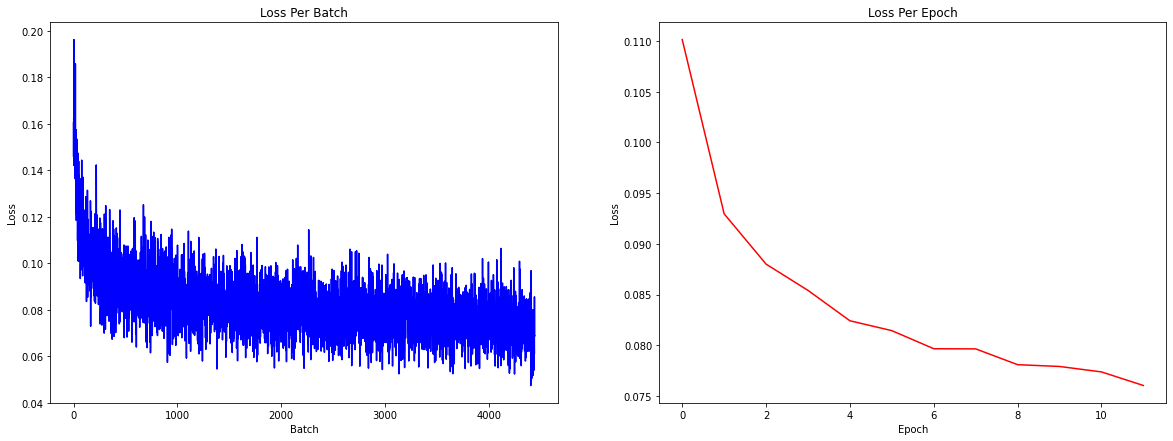

In [113]:
import matplotlib.pyplot as plt
# Batch loss
batch_losses = np.copy(train.losses)
batch_count = len(batch_losses) // train.epoch_max
print("# batches in epoch: {}".format(batch_count))
epoch_losses = []
for b in range(12):
    start = b*batch_count
    end = ((b+1)*batch_count) - 1
    # print("{}, {}".format(start, end))
    epoch_losses.append(np.average(batch_losses[start:end]))

plt.figure(1, figsize=(20,7))
plt.subplot(121)
plt.plot(range(len(batch_losses)), batch_losses, 'b')
plt.title("Loss Per Batch")
plt.xlabel("Batch")
plt.ylabel("Loss")

plt.subplot(122)
plt.plot(range(len(epoch_losses)), epoch_losses, 'r')
plt.title("Loss Per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()


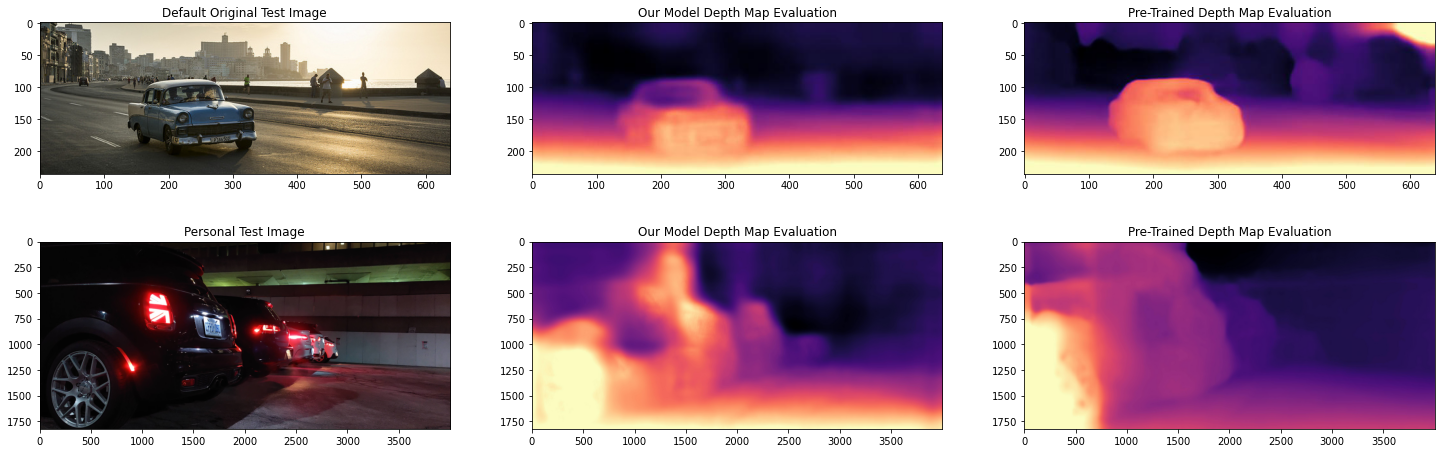

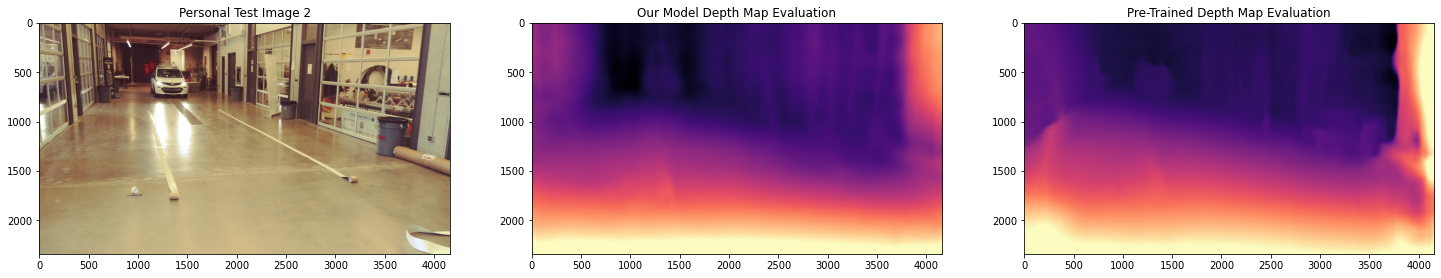

In [127]:
import matplotlib.pyplot as plt

plt.figure(2, figsize=(25, 8))
test_image = pil.open("monodepth2/assets/test_image.jpg")
plt.subplot(231)
plt.imshow(test_image)
plt.title("Default Original Test Image")

test_image = pil.open("monodepth2/assets/our_model/test_image_disp.jpeg")
plt.subplot(232)
plt.imshow(test_image)
plt.title("Our Model Depth Map Evaluation")

test_image = pil.open("monodepth2/assets/test_image_disp.jpeg")
plt.subplot(233)
plt.imshow(test_image)
plt.title("Pre-Trained Depth Map Evaluation")

test_image = pil.open("monodepth2/assets/alexa_cars.jpg")
plt.subplot(234)
plt.imshow(test_image)
plt.title("Personal Test Image")

test_image = pil.open("monodepth2/assets/our_model/alexa_cars_disp.jpeg")
plt.subplot(235)
plt.imshow(test_image)
plt.title("Our Model Depth Map Evaluation")

test_image = pil.open("monodepth2/assets/alexa_cars_disp.jpeg")
plt.subplot(236)
plt.imshow(test_image)
plt.title("Pre-Trained Depth Map Evaluation")


plt.figure(3, figsize=(25,8))
test_image = pil.open("monodepth2/assets/wato.jpg")
plt.subplot(131)
plt.imshow(test_image)
plt.title("Personal Test Image 2")

test_image = pil.open("monodepth2/assets/our_model/wato_disp.jpeg")
plt.subplot(132)
plt.imshow(test_image)
plt.title("Our Model Depth Map Evaluation")

test_image = pil.open("monodepth2/assets/wato_disp.jpeg")
plt.subplot(133)
plt.imshow(test_image)
plt.title("Pre-Trained Depth Map Evaluation")

plt.show()

### Training Loss Visual Inspection
The training loss plotted above shows that the model is slowly converging to an optimum value after ~11 epochs. Although the training loss does not fully flatten out (i.e. stops improving), it was found experimentally that further training tended to overfit the model, and so decrease the validation loss.

We see that the model does a good job at predicting depth of images in the validation set. This shows that the model is not overfitting to the training data, and is therefore extensib

Comparing the results against a pre-trained version of the model from [1] shows comparable results. It is important to note that the pretrained model was trained using the original Loss function (that is, not weighing the loss more heavily near object edges), and it was trained on 750GB worth of KITTI data. In contrast, we are able to achieve comparable results, with a datset of only ~3000 images, and a 85/15 training/validation split. The additional term in the loss function (weighing loss propoertional to gradient intensity) appears to have had a positive effect on the training, as our model is able to maintain edge resolution and overall good results despite the smaller dataset.

Below, we show loss comparisons for the pretrained and our trained model.le.

In [55]:
! du -cs --block-size=M test_model
! zip test_model.zip test_model/*
! cp test_model.zip "gdrive/MyDrive/CS484_Models/test_20e_12b_depth_bigger_data.zip"

216M	test_model
216M	total
  adding: test_model/adam.pth (deflated 8%)
  adding: test_model/depth.pth (deflated 8%)
  adding: test_model/encoder.pth (deflated 7%)
  adding: test_model/losses.txt (deflated 56%)
  adding: test_model/pose_encoder.pth (deflated 7%)
  adding: test_model/pose.pth (deflated 9%)


In [96]:
! python monodepth2/export_gt_depth.py --data_path kitti_data --split eigen_small_val
print("EVALULATION ON VALIDATION SET RESULTS")
! python monodepth2/evaluate_depth.py --data_path kitti_data --eval_split eigen_small_val --load_weights_folder /content/test_model --eval_stereo

EVALULATION ON VALIDATION SET RESULTS
-> Loading weights from /content/test_model
-> Computing predictions with size 640x192
-> Evaluating
   Stereo evaluation - disabling median scaling, scaling by 5.4

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   0.112  &   1.583  &   6.385  &   0.235  &   0.878  &   0.941  &   0.970  \\

-> Done!


In [102]:
! python monodepth2/export_gt_depth.py --data_path kitti_data --split eigen_small_train
print("EVALULATION ON TRAINING SET RESULTS")
! python monodepth2/evaluate_depth.py --data_path kitti_data --eval_split eigen_small_train --load_weights_folder /content/test_model --eval_stereo

Exporting ground truth depths for eigen_small_train
Saving to eigen_small_train
tcmalloc: large alloc 1076043776 bytes == 0x60f9e000 @  0x7ff369a101e7 0x7ff36755041e 0x7ff3675a0bdb 0x7ff3675a3f23 0x7ff3675a411b 0x7ff367645561 0x50a4a5 0x50beb4 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x50ad03 0x634e72 0x634f27 0x6386df 0x639281 0x4b0dc0 0x7ff36960dbf7 0x5b259a
EVALULATION ON TRAINING SET RESULTS
-> Loading weights from /content/test_model
-> Computing predictions with size 640x192
tcmalloc: large alloc 1076043776 bytes == 0xae484000 @  0x7ff31806e1e7 0x7ff30e2ab41e 0x7ff30e2fbbdb 0x7ff30e2aec98 0x551555 0x5a9dac 0x50a433 0x50cc96 0x507be4 0x509900 0x50a2fd 0x50cc96 0x508cd5 0x594a01 0x59fd0e 0x5576d8 0x50c19e 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x50ad03 0x634e72 0x634f27 0x6386df 0x639281 0x4b0dc0 0x7ff317c6bbf7 0x5b259a
-> Evaluating
   Stereo evaluation - disabling median scaling, scaling by 5.4

   abs_rel |   sq_rel |     rmse | rmse_log |       a1 |       a2 |       a3 | 
&   

## Comparing Training and Validation Loss

It is shown that the validation loss is not considerably higher than the training loss. As such, we conclude that the model did not overfit to the training data.

It is also important to note that the results shown above are only slightly worse than the results reported in [1] of absolute relative error = 0.109 on the validation set, when trained only on stereo data. Our network shows an absolute relative error of 0.112 on the validation set, and 0.109 on the training set.

This shows promising results. It more computational capacity was available, and considerably longer amounts of time for training, we would be able to train on the whole KITTI dataset, which would provide more diversity in the data and hence more extensible results. It would thus lower the loss for the validation dataset, and improve inference performance on never-before-seen data.

## Improvements

In earlier versions of the project, we noticed that the neural network seemed to be overfitting to the training dataset, given that the training loss was much lower than the validation loss. To fix this, we reduced the number of epochs the network was trained on and randomized the training batches. Note that one of the most probably causes for said overitting was the limited dataset being used. The training was performed on Google Colab, which offers limited storage and memory. As such, a small subset of the KITTI stereo dataset was used (750 images).

We also noticed that the loss seemed to be dropping relatively fast at first, and then staying fairly constant. In this constant state, however, it was very noisy. In an attempt to mitigate this issue, we reduced the learning rate, which allowed for a more gradual and less noisy backpropagation of the weights. Additionally, the batch size was increased to the max size allowable before getting CUDA out of memory errors. Increasing the batch size also helped stabilize the loss function over time, by providing a more hollistic value for the loss on the dataset, rather than on individual images.

Lastly, and most notably, we noticed that the depth predictions around object edges tended to be blurry, and not closely match the depth discontinuities at the edges of objects. This is caused by the depth smoothness term in the loss function, which prevents high-frequency noise in the predictions, at the cost of losing resolution around the edges. As such, a new term was added to the loss function, which penalizes the loss of pixels around object edges more heavily. A horizontal and vertical edge detection convolution was carried out. These masks were then added and Gaussian blur was applied in order to make the loss weighing be smoother around the edges. Then the mask was normalize\d to  [1,1+𝑏\𝑒𝑡𝑎] , for  𝑏𝑒𝑡𝑎<1  representing the relative weighting of this edge-resolution loss term with respct to the smoothness and photoconsistency terms. The results increased slightly for small beta values; increasing beta by too much showed detrimental performance, as the training process would overcorrect in order to minimize the loss specifically at these edges.

# Conclusions

We have shown that learning depth estimation from a single image is possible using a self-supervised method in which no ground truth is used to compute the loss. Rather, stereo pairs are compared against their respective synthetic image (as described in the Introduction) as a way of measuring the quality of the predictions.

Qualitatively, the depth maps produced look accurate. Further work could be done in comparing the results against ground truth depth maps, given that KITTI provides means of acquiring these), in order to provide quantitative results. Note that this would, however, defeat the purpose of using self-supervised models, and so in a general case, it is possible to be able to analyze and quantify the performance of the network without access to ground-truth data. This is why we present comparisons of the training and validation loss. Doing so allows for comparisons between the data the network was trained on, and data it has never seen.

In early iterations of the project, we detected potential overfitting of the network. This was in part due to the limited size of the dataset,and the large number of epochs used to train. Decreasing the number of epochs, and reducing the learning rate allowed the network to converge to better local optima, and hence better generalise to the validation dataset. Note that the size of the dataset was a fairly limiting barrier we encountered (trained on merely 750 images); this was due to limited computational resources available, as we used Google Colab, which offers limited storge and memory.

Overall the results look promising. Performing good quality depth estimation from single images greatly reduces the cost and complexity of training these models for different scenarios where multi camera or LiDAR data might not be available. Additionally, it has concrete applications in fields like Augmented Reality, where a depth map of the environment must be generated in order to place "holograms", often from phones with a single camera.

# References

[1] https://arxiv.org/pdf/1806.01260.pdf

[2] https://arxiv.org/pdf/1511.08861.pdf